## Physics Informed Neural Networks for Inverse Problems

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

from os.path import join
import pandas as pd

import datetime
import json

Consider the one-dimensional heat equation:

$$
u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0,
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

The equation parameter $k:[0,T]\times[-1,1]\mapsto \mathbb{R} $ denotes the medium conductivity and $s:[0,T]\times[-1,1]\mapsto \mathbb{R}$ is a source term.

We want to solve a parameter identification inverse problem, which can be formulated as follows:

Given observation measurements of the medium temperature

$$
S_{meas}=\{(t_i, x_i, u^{meas}_{i})\}_{i=1}^{N_{meas}},
$$
find $u: [0,T]\times[-1,1]\mapsto\mathbb{R}$ and $k:[-1,1]\mapsto \mathbb{R}$, such that

$$u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t,x),
\\ u_b(t, -1)=u_b(t,1)=0 \quad\text{   and  } \quad u(x, 0) = u_0(x) = -\sin(\pi x).$$






\\


To do so, we approximate the underlying solution and the medium conductivity with two feedforward dense neural network with tunable parameters $\theta$ and $\phi$:

$$
u_\theta(t,x) \approx u(t,x), \quad k_\phi(t, x) \approx k(t, x)
$$

In [178]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.output_activation=nn.ReLU()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_activation(self.output_layer(x))

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


We define the following residuals:

   - Interior residual given by,
   $$r_{int,\theta, \phi}(t, x):=  u_{\theta, t}(t, x) - k_\phi(t,x)u_{\theta, xx}(t, x) -s(t,x), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   

        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta, \phi) = \int_{[0,T]\times[-1,1]}r_{int,\theta, \phi}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad 1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences:

$$
L_{int}(\theta, \phi) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta,\phi}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

Also the measurements data $S_{meas}$ have to taken into account. To do so, we define ad additional loss term:
$$
L_{meas} = \frac{1}{N_{meas}}\sum_{i=1}^{N_{mean}}(u_\theta(t_i, x_i) - u^{meas}_i)^2(x_n)
$$
and eventually solve the following minimization problem

$$
\theta^\ast, \phi^\ast = argmin_{\theta, \phi} \Big(L_{int}(\theta, \phi) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta) + L_{meas}(\theta)
$$

\\

\\

\\

In the following let us assume

$$u_{ex}(t,x) = -\exp(-\pi^2 t)\sin(\pi x), \quad k(t,x)=k(x)=\sin(\pi x).$$

Then, the source term $s$ can be computed by plugging the expression above in the PDE:

$$
s(t,x) = -\pi^2u_{ex}(t,x)*(1 - k(t,x))
$$

Moreover, let us assume that the measurments data are given as follows:

$$
u_{meas}(x_i, t_i) = u_{ex}(x_i t_i) + 0.01\xi, \quad \xi \sim \mathcal{N(0, 1)}
$$

where $\mathcal{N(0, 1)}$ is a standard normal distribution.



In [179]:
# Initial condition to solve the heat equation u0(x)=-sin(pi x)
def initial_condition(x):
    return torch.ones(x.shape[0],1)

# Exact solution for the heat equation ut = u_xx with the IC above
def exact_solution(inputs):
    t = inputs[:, 0]
    x = inputs[:, 1]

    u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
    return u

def exact_conductivity(inputs):
    t = inputs[:, 0]
    x = inputs[:, 1]
    k = (torch.sin(np.pi * x) + 1.1)

    return k


def source(inputs):
    s = -np.pi**2*exact_solution(inputs)*(1 - exact_conductivity(inputs))
    return s

def fluid_flow(t):
    zero=torch.zeros(t.shape).to(t.device)
    return(
        torch.heaviside(t,zero)-torch.heaviside(t-1.0,zero)-torch.heaviside(t-2.0,zero)+torch.heaviside(t-3.0,zero)
        +torch.heaviside(t-4.0,zero)-torch.heaviside(t-5.0,zero)-torch.heaviside(t-6.0,zero)+torch.heaviside(t-7.0,zero)
    )

In [180]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, architecture="single",use_rois=True):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.n_roi=n_int_//4

        self.use_rois=use_rois
        self.architecture = architecture

        # Extrema of the solution domain (t,x) in [0,8] x [0,1]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        self.rois = [
            torch.tensor([[0, 1.5], [0, 0.2]]),
            torch.tensor([[3.7, 5.5], [0, 0.2]]),
            torch.tensor([[0, 8], [0.25, 0.7]]),
            torch.tensor([[0, 0.2], [0., 1.]]),
            torch.tensor([[1.9, 4.1], [0.5, 1.]]),
            torch.tensor([[5.9, 8], [0.5, 1.]]),
            torch.tensor([[3.8, 4.2], [0., 0.05]])
        ]

        for i in range(1,8):
            self.rois.append(torch.tensor([[i-0.2, i+0.2], [0., 1.]]))

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_boundary = 10
        self.lambda_pde=10

        # PDE Coefficients
        self.T_hot=4
        self.T_cold=1
        self.alpha_f=0.005
        self.h_f=5

        # Model hyperparameters
        tf_params={"n_hidden_layers": 4, "n_neurons": 32, "hidden_layer_activation": "tanh", "output_activation":"relu"}
        self.tf_params=tf_params

        ts_params={"n_hidden_layers": 4, "n_neurons": 32, "hidden_layer_activation": "tanh", "output_activation":"relu"}
        self.ts_params=ts_params

        # set seed for reproducibility
        self.seed=42

        # Filepath to the measurement data
        self.measurement_data_filepath = join("..","data","Task2","DataSolution.txt")

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if self.architecture=="single":
            self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=self.tf_params["n_hidden_layers"],
                                              neurons=self.tf_params["n_neurons"],
                                              retrain_seed=self.seed).to(self.device)

        else:

            # FF Dense NN to approximate the solution of the underlying heat equation
            self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                                n_hidden_layers=self.tf_params["n_hidden_layers"],
                                                neurons=self.tf_params["n_neurons"],
                                                retrain_seed=self.seed).to(self.device)

            # FF Dense NN to approximate the conductivity we wish to infer
            self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0],
                                                    output_dimension=1,
                                                    n_hidden_layers=self.ts_params["n_hidden_layers"],
                                                    neurons=self.ts_params["n_neurons"],
                                                    retrain_seed=self.seed).to(self.device)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

        # number of sensors to record temperature
        self.n_sensor = 50

        self.metadata_path=join("..","logs", "task_2")

        self.pde_loss=0
        self.function_loss=0
        self.data_loss=0

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def convert_range(self, tens, domain):
        assert tens.shape[1] == self.domain_extrema.shape[0]
        return (
            tens * (domain[:, 1] - domain[:, 0])
            + domain[:, 0]
        )

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        x0_input_list=[]
        xL_input_list=[]

        x0_output_list = []
        xL_output_list = []

        n_sb_per_domain=self.n_sb//8

        for i in range(8):
            domain = torch.tensor([[i, i+1], [0, 1]])  # Time dimension  # Space dimension

            input_sb_section=self.convert_range(self.soboleng.draw(n_sb_per_domain),domain )
            input_sb_section_0 = torch.clone(input_sb_section)
            input_sb_section_0[:, 1] = torch.full(input_sb_section_0[:, 1].shape, x0)

            input_sb_section_L = torch.clone(input_sb_section)
            input_sb_section_L[:, 1] = torch.full(input_sb_section_L[:, 1].shape, xL)

            x0_input_list.append(input_sb_section_0)
            xL_input_list.append(input_sb_section_L)

            if i%4==0: # charging
                output_sb_section_0 =self.T_hot*torch.ones((input_sb_section_0.shape[0], 1))
                output_sb_section_L =torch.zeros((input_sb_section_0.shape[0], 1))

            elif i%4==2: # discharging
                output_sb_section_0 =torch.zeros((input_sb_section_0.shape[0], 1))
                output_sb_section_L =self.T_cold*torch.ones((input_sb_section_0.shape[0], 1))

            elif i%2==1: #idle
                output_sb_section_0 = torch.zeros((input_sb_section_0.shape[0], 1))
                output_sb_section_L = torch.zeros((input_sb_section_0.shape[0], 1))

            x0_output_list.append(output_sb_section_0)
            xL_output_list.append(output_sb_section_L)

        # input_sb = self.convert(self.soboleng.draw(self.n_sb))

        # input_sb_0 = torch.clone(input_sb)
        # input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        # input_sb_L = torch.clone(input_sb)
        # input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        # output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat(x0_input_list+ xL_input_list, 0), torch.cat(x0_output_list+ xL_output_list, 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        inputs=[input_int]
        outputs=[output_int]
        if self.use_rois:
            for roi in self.rois:
                input_int_roi = self.convert_range(
                    self.soboleng.draw(self.n_roi), roi
                )
                output_int_roi = torch.zeros((input_int_roi.shape[0], 1))
                inputs.append(input_int_roi)
                outputs.append(output_int_roi)
        return torch.cat(inputs,0), torch.cat(outputs,0)

    def get_measurement_data(self):
        # torch.random.manual_seed(42)
        # # take measurments every 0.001 sec on a set of randomly placed (in space) sensors
        # t = torch.linspace(0, self.domain_extrema[0, 1], 25)
        # x = torch.linspace(self.domain_extrema[1, 0], self.domain_extrema[1, 1], self.n_sensor)

        # # x = torch.rand(self.n_sensor)
        # # x = x * (self.domain_extrema[1, 1] - self.domain_extrema[1, 0]) +  self.domain_extrema[1, 0]

        # input_meas = torch.cartesian_prod(t, x)

        # output_meas = exact_solution(input_meas).reshape(-1,1)
        # noise = 0.01*torch.randn_like(output_meas)
        # output_meas = output_meas + noise

        measurements=torch.tensor(pd.read_csv(self.measurement_data_filepath,header=0).values, dtype=torch.float32)
        input_meas=measurements[:,0:2]
        output_meas=measurements[:,2].reshape(-1,1)

        return input_meas.to(self.device), output_meas.to(self.device)

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int + len(self.rois)*self.n_roi, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        if self.architecture =="single":
            u_pred_tb = self.approximate_solution(input_tb)[:,0].reshape(-1,1)
        else:
            u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True
        if self.architecture =="single":
            u_pred_sb = self.approximate_solution(input_sb)[:,0].reshape(-1,1)
        else:
            u_pred_sb = self.approximate_solution(input_sb)

        grad_u_x=torch.autograd.grad(u_pred_sb.sum(), input_sb, create_graph=True)[0][:, 1]

        return u_pred_sb, grad_u_x

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        if self.architecture =="single":
            out=self.approximate_solution(input_int)
            T_f = out[:,0].reshape(-1,)
            T_s=out[:,1].reshape(-1,)
            # T_f = self.approximate_solution(input_int)[:,0].reshape(-1,)
            # T_s = self.approximate_solution(input_int)[:,1].reshape(-1,)
        else:
            T_f = self.approximate_solution(input_int).reshape(-1,)
            T_s = self.approximate_coefficient(input_int).reshape(-1,)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        # s = source(input_int)

        with torch.no_grad():
            U_f = fluid_flow(input_int[:,0])

        residual = grad_u_t + U_f*grad_u_x - self.alpha_f*grad_u_xx+self.h_f*(T_f-T_s)

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):

        u_pred_sb, grad_u_sb_x = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        inp_train_meas, u_train_meas = self.get_measurement_data()
        if self.architecture =="single":
            u_pred_meas = self.approximate_solution(inp_train_meas)[:,0].reshape(-1,1)
        else:
            u_pred_meas = self.approximate_solution(inp_train_meas)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        # r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        r_sb=grad_u_sb_x.clone()
        section_length=self.n_sb//8
        for i in [0,4]: # dirichlet conditions for charging phase at x0
            r_sb[i * section_length : (i + 1) * section_length] = (
                u_pred_sb[i * section_length : (i + 1) * section_length]
                - u_train_sb[i * section_length : (i + 1) * section_length]
            ).reshape(-1,)

        for i in [10,14]: # dirichlet conditions for discharging phase at xL
            r_sb[i * section_length : (i + 1) * section_length] = (
                u_pred_sb[i * section_length : (i + 1) * section_length]
                - u_train_sb[i * section_length : (i + 1) * section_length]
            ).reshape(-1,)

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        # loss_u = loss_sb + loss_tb + loss_meas
        loss_boundary = loss_sb + loss_tb

        self.function_loss = round(torch.log10(loss_boundary).item(), 4)
        self.pde_loss = round(torch.log10(loss_int).item(), 4)
        self.data_loss = round(torch.log10(loss_meas).item(), 4)

        loss = torch.log10(self.lambda_boundary * loss_boundary + self.lambda_pde*loss_int+loss_meas)
        if verbose:
            print(
                "Total loss: ",
                round(loss.item(), 4),
                "| PDE Loss: ",
                self.pde_loss,
                "| Boundary Loss: ",
                self.function_loss,
                "| Data Loss: ",
                self.data_loss,
            )

        return loss

    # def save(self, loss_history=None):
    #     now = datetime.datetime.now().strftime("%m-%d %H:%M:%S")
    #     filename_tf=join("..","models", "task_2", now+"_tf.pt")
    #     filename_ts=join("..","models", "task_2", now+"_ts.pt")

    #     salient_info={}
    #     # salient_info["n_hidden_layers"]=self.n_hidden_layers
    #     # salient_info["n_neurons"]=self.n_neurons
    #     if loss_history is not None:
    #         salient_info["final_loss"]=loss_history[-1]
    #         salient_info["min_loss"]=min(loss_history)
    #     salient_info["use_rois"]=self.use_rois
    #     salient_info["architecture"]=self.architecture
    #     salient_info["tf_model_path"]=filename_tf
    #     salient_info["ts_model_path"]=filename_ts
    #     salient_info["seed"]=self.seed
    #     salient_info["tf_model_hyperparams"]=self.tf_params
    #     salient_info["ts_model_hyperparams"]=self.ts_params
    #     salient_info["lambda"]=self.lambda_u
    #     salient_info["rois"]=[roi.numpy().tolist() for roi in self.rois]
    #     salient_info["n_int"]=self.n_int
    #     salient_info["n_sb"]=self.n_sb
    #     salient_info["n_tb"]=self.n_tb
    #     salient_info["n_roi"]=self.n_roi

    #     if self.architecture=="single":
    #         torch.save(self.approximate_solution.state_dict(), filename_tf)
    #     else:

    #         torch.save(self.approximate_solution.state_dict(), filename_tf)
    #         torch.save(self.approximate_coefficient.state_dict(), filename_ts)

    #     metadata_file=join(self.metadata_path, "metadata_"+now+".json")

    #     with open(metadata_file, "a") as f:
    #         json.dump(salient_info, f)

In [181]:
def save(pinn: Pinns, loss_history=None):
    now = datetime.datetime.now().strftime("%m%d-%H%M%S")
    final_loss_str=str(round(loss_history[-1],3)) if loss_history is not None else ""

    filename_tf = join("..", "models", "task_2", now +"_"+final_loss_str+ "_tf.pt")
    filename_ts = join("..", "models", "task_2", now + "_" + final_loss_str + "_ts.pt")
    filename_joint = join(
        "..", "models", "task_2", now + "_" + final_loss_str + "_joint.pt"
    )

    salient_info = {}
    # salient_info["n_hidden_layers"]=self.n_hidden_layers
    # salient_info["n_neurons"]=self.n_neurons
    if loss_history is not None:
        salient_info["final_loss"] = loss_history[-1]
        salient_info["min_loss"] = min(loss_history)
    salient_info["pde_loss"] = pinn.pde_loss
    salient_info["function_loss"] = pinn.function_loss
    salient_info["data_loss"] = pinn.data_loss
    salient_info["use_rois"] = pinn.use_rois
    salient_info["architecture"] = pinn.architecture
    if pinn.architecture == "single":
        salient_info["model_path"] = filename_joint
    else:
        salient_info["tf_model_path"] = filename_tf
        salient_info["ts_model_path"] = filename_ts
    salient_info["seed"] = pinn.seed
    salient_info["tf_model_hyperparams"] = pinn.tf_params
    salient_info["ts_model_hyperparams"] = pinn.ts_params
    salient_info["boundary lambda"] = pinn.lambda_boundary
    salient_info["pde lambda"] = pinn.lambda_pde
    salient_info["rois"] = [roi.numpy().tolist() for roi in pinn.rois]
    salient_info["n_int"] = pinn.n_int
    salient_info["n_sb"] = pinn.n_sb
    salient_info["n_tb"] = pinn.n_tb
    salient_info["n_roi"] = pinn.n_roi


    if pinn.architecture == "single":
        torch.save(pinn.approximate_solution.state_dict(), filename_joint)
    else:

        torch.save(pinn.approximate_solution.state_dict(), filename_tf)
        torch.save(pinn.approximate_coefficient.state_dict(), filename_ts)

    metadata_file = join(pinn.metadata_path, "metadata_" + now + ".json")

    with open(metadata_file, "a") as f:
        json.dump(salient_info, f)

Define *fit* function that takes model, num_epoch and optimizer as an input.

It runs the gradient descent and returns history of the loss computed at each epoch (using closure rule, as below).

In [182]:
def fit(model, num_epochs, optimizer, verbose=True):
    history = list()
    device=model.device
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(model.training_set_sb, model.training_set_tb, model.training_set_int)):
            def closure():
                optimizer.zero_grad()
                loss = model.compute_loss(inp_train_sb.to(device), u_train_sb.to(device), inp_train_tb.to(device), u_train_tb.to(device), inp_train_int.to(device), verbose=verbose)
                loss.backward()

                history.append(loss.item())
                return loss

            optimizer.step(closure=closure)

    print('Final Loss: ', history[-1])

    return history

Use the code below to plot the exact and the approximate solutions:

In [183]:
def plotting(model):
    inputs = model.soboleng.draw(100000)
    inputs = model.convert(inputs).to(model.device)

    if model.architecture=="single":
        out=model.approximate_solution(inputs)
        output = out[:,0].reshape(-1,)
        approx_cond = out[:,1].reshape(-1,)
    else:
        output = model.approximate_solution(inputs).reshape(
            -1,
        )

        approx_cond = model.approximate_coefficient(inputs).reshape(
            -1,
        )
    approx_cond=approx_cond.cpu()
    output = output.cpu()
    inputs=inputs.cpu()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

    im1 = axs[0].scatter(
        inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet"
    )
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Approximate T_f")

    im2 = axs[1].scatter(
        inputs[:, 1].detach(), inputs[:, 0].detach(), c=approx_cond.detach(), cmap="jet", vmax=4
    )
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("Approximate T_s")

    plt.show()

In [184]:
def mesh_plotting(model, print_max=False):
    # inputs = model.soboleng.draw(100000)
    # inputs = model.convert(inputs).to(model.device)
    num_points_x = 120
    num_points_t = 800

    # Creating mesh grid
    x_values = np.linspace(0, 1, num_points_x)  # Adjust range as per your requirement
    t_values = np.linspace(0, 8, num_points_t)  # Adjust range as per your requirement
    X, T = np.meshgrid(x_values, t_values)

    # Reshape mesh grid for model input
    inputs = np.column_stack((np.ravel(T), np.ravel(X)))
    inputs = torch.tensor(inputs).float().to(model.device)

    if model.architecture=="single":
        out=model.approximate_solution(inputs)
        approx_tf = out[:,0].reshape(-1,)
        approx_ts = out[:, 1].reshape(-1,)

    else:
        approx_tf = model.approximate_solution(inputs).reshape(
            -1,
        )

        approx_ts = model.approximate_coefficient(inputs).reshape(
            -1,
        )

    approx_tf = approx_tf.cpu()
    approx_ts = approx_ts.cpu()

    inputs = inputs.cpu()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

    # Colormesh plot for Approximate T_f
    # im1 = axs[0].pcolormesh(
    #     inputs[:, 1].detach(), inputs[:, 0].detach(), approx_tf.detach(), cmap="jet"
    # )
    # im1 = axs[0].pcolormesh(
    #     [x_values, t_values], approx_tf.detach(), cmap="jet"
    # )
    im1=axs[0].pcolormesh(approx_tf.reshape(num_points_t,num_points_x).detach(), cmap="jet",vmax=6)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Approximate T_f")
    
    if print_max:
        print("Max T_f: ", torch.max(approx_tf).item(), " | MMaxin T_s: ", torch.max(approx_ts).item())

    # Colormesh plot for Approximate T_s
    # im2 = axs[1].pcolormesh(
    #     inputs[:, 1].detach(), inputs[:, 0].detach(), approx_ts.detach(), cmap="jet"
    # )
    im2=axs[1].pcolormesh(approx_ts.reshape(num_points_t,num_points_x).detach(), cmap="jet",vmax=6)
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("Approximate T_s")

    plt.show()

Let us test the code:




In [185]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 2048
n_sb = 512
n_tb = 512
architecture="double"
use_rois=True

pinn = Pinns(n_int, n_sb, n_tb, architecture=architecture,use_rois=use_rois)

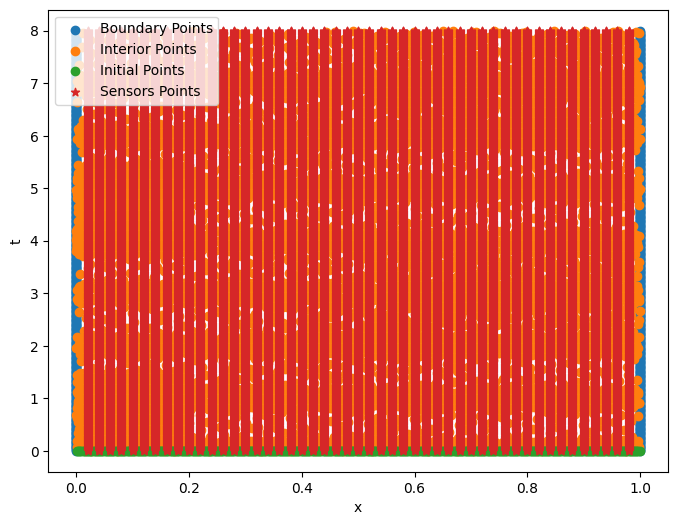

In [186]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().cpu().numpy(), input_meas_[:, 0].detach().cpu().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [187]:
n_epochs = 5
max_iter = 50000
if pinn.architecture=="single":
    parameters=list(pinn.approximate_solution.parameters())
else:
    parameters=list(pinn.approximate_solution.parameters())+list(pinn.approximate_coefficient.parameters())
optimizer_LBFGS = optim.LBFGS(parameters,
                              lr=float(0.5),
                              max_iter=max_iter,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(parameters,
                            lr=float(0.005))

In [188]:
hist = fit(pinn,
          num_epochs=n_epochs,
          optimizer=optimizer_LBFGS,
          verbose=True)
# pinn.save(hist)
save(pinn,hist)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

################################  0  ################################
Total loss:  1.4954 | PDE Loss:  0.143 | Boundary Loss:  0.2246 | Data Loss:  -0.2095
Total loss:  1.4264 | PDE Loss:  -0.048 | Boundary Loss:  0.2335 | Data Loss:  -0.206
Total loss:  1.3861 | PDE Loss:  -0.1812 | Boundary Loss:  0.2336 | Data Loss:  -0.2119
Total loss:  1.3583 | PDE Loss:  -0.277 | Boundary Loss:  0.2287 | Data Loss:  -0.2204
Total loss:  1.3399 | PDE Loss:  -0.3369 | Boundary Loss:  0.2222 | Data Loss:  -0.2281
Total loss:  1.3208 | PDE Loss:  -0.3918 | Boundary Loss:  0.2121 | Data Loss:  -0.2363
Total loss:  1.2977 | PDE Loss:  -0.4425 | Boundary Loss:  0.195 | Data Loss:  -0.2445
Total loss:  1.2658 | PDE Loss:  -0.476 | Boundary Loss:  0.1624 | Data Loss:  -0.2496
Total loss:  1.2187 | PDE Loss:  -0.4547 | Boundary Loss:  0.0953 | Data Loss:  -0.2345
Total loss:  1.1747 | PDE Loss:  -0.4718 | Boundary Loss:  0.0389 | Data Loss:  -0.1939
Total loss:  1.0988 | PDE Loss:  -0.5728 | Boundary Loss:

KeyboardInterrupt: 

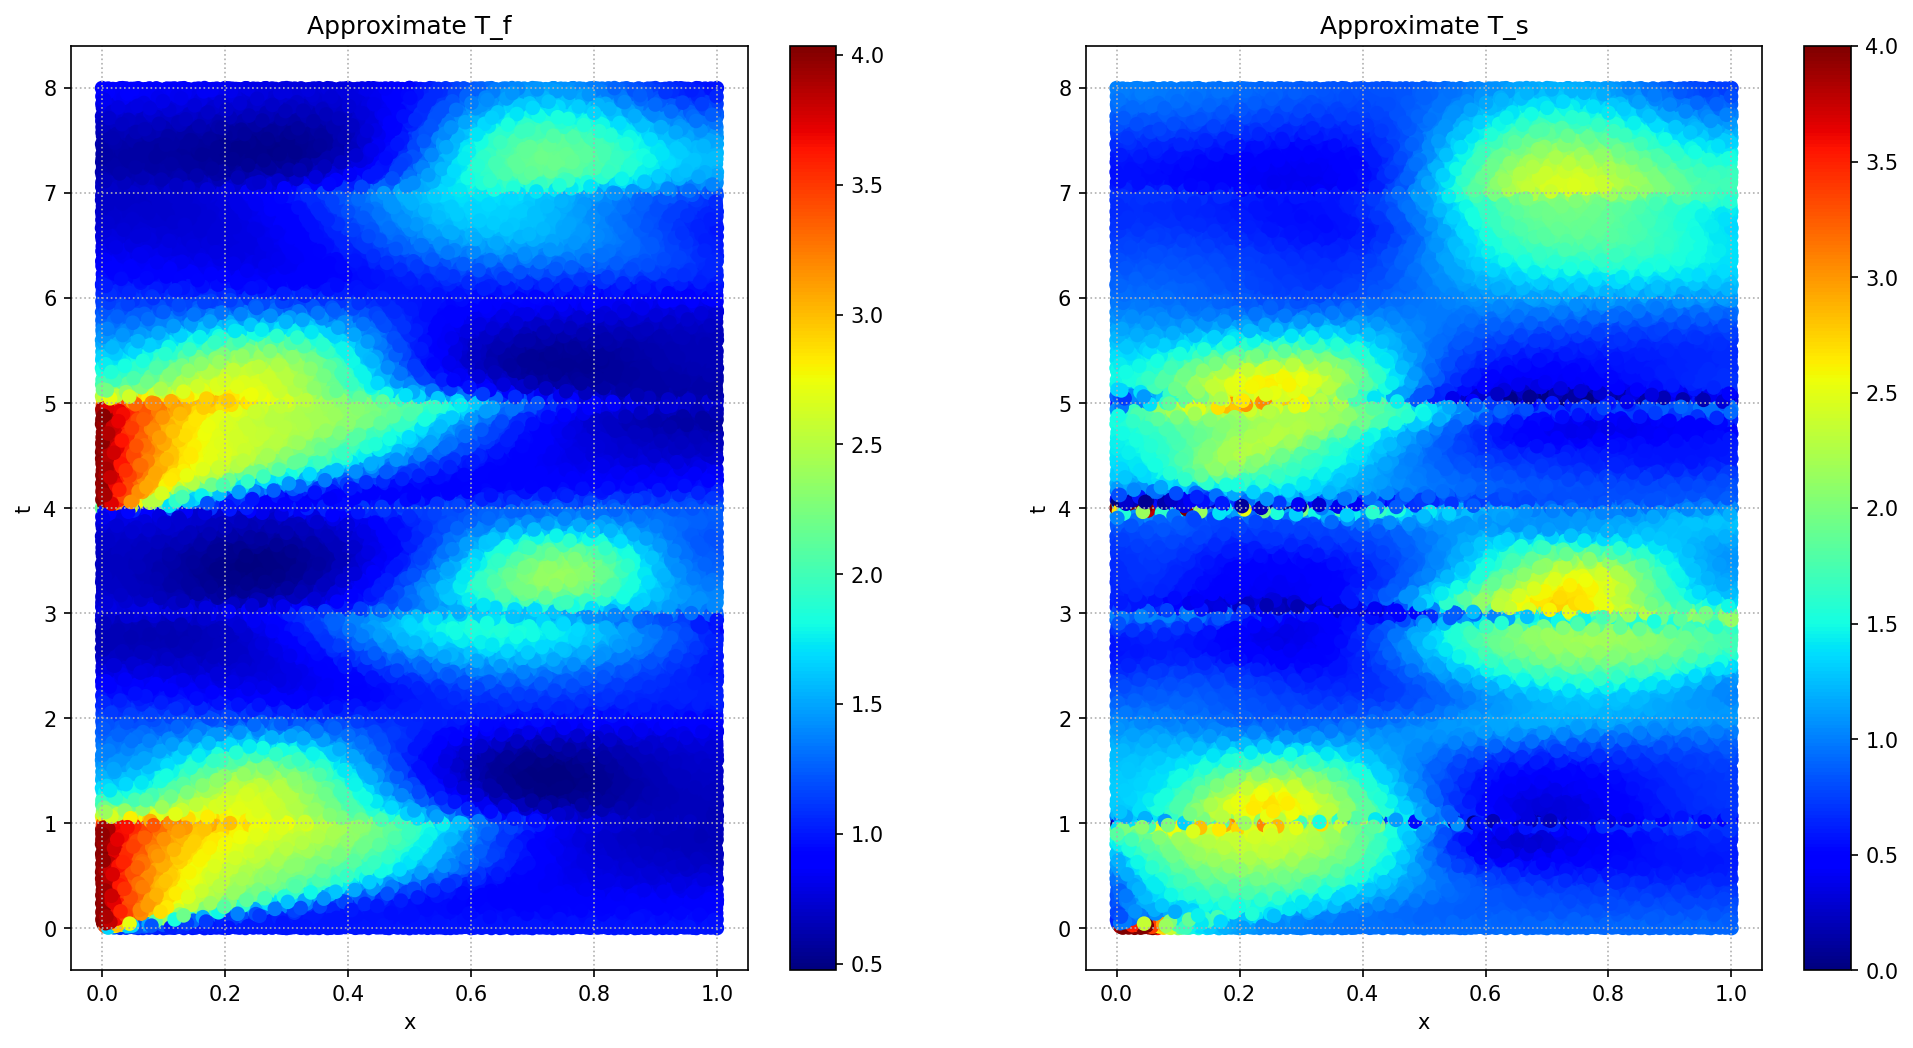

In [ ]:
plotting(pinn)

Max T_f:  4.278221607208252  | MMaxin T_s:  24.188032150268555


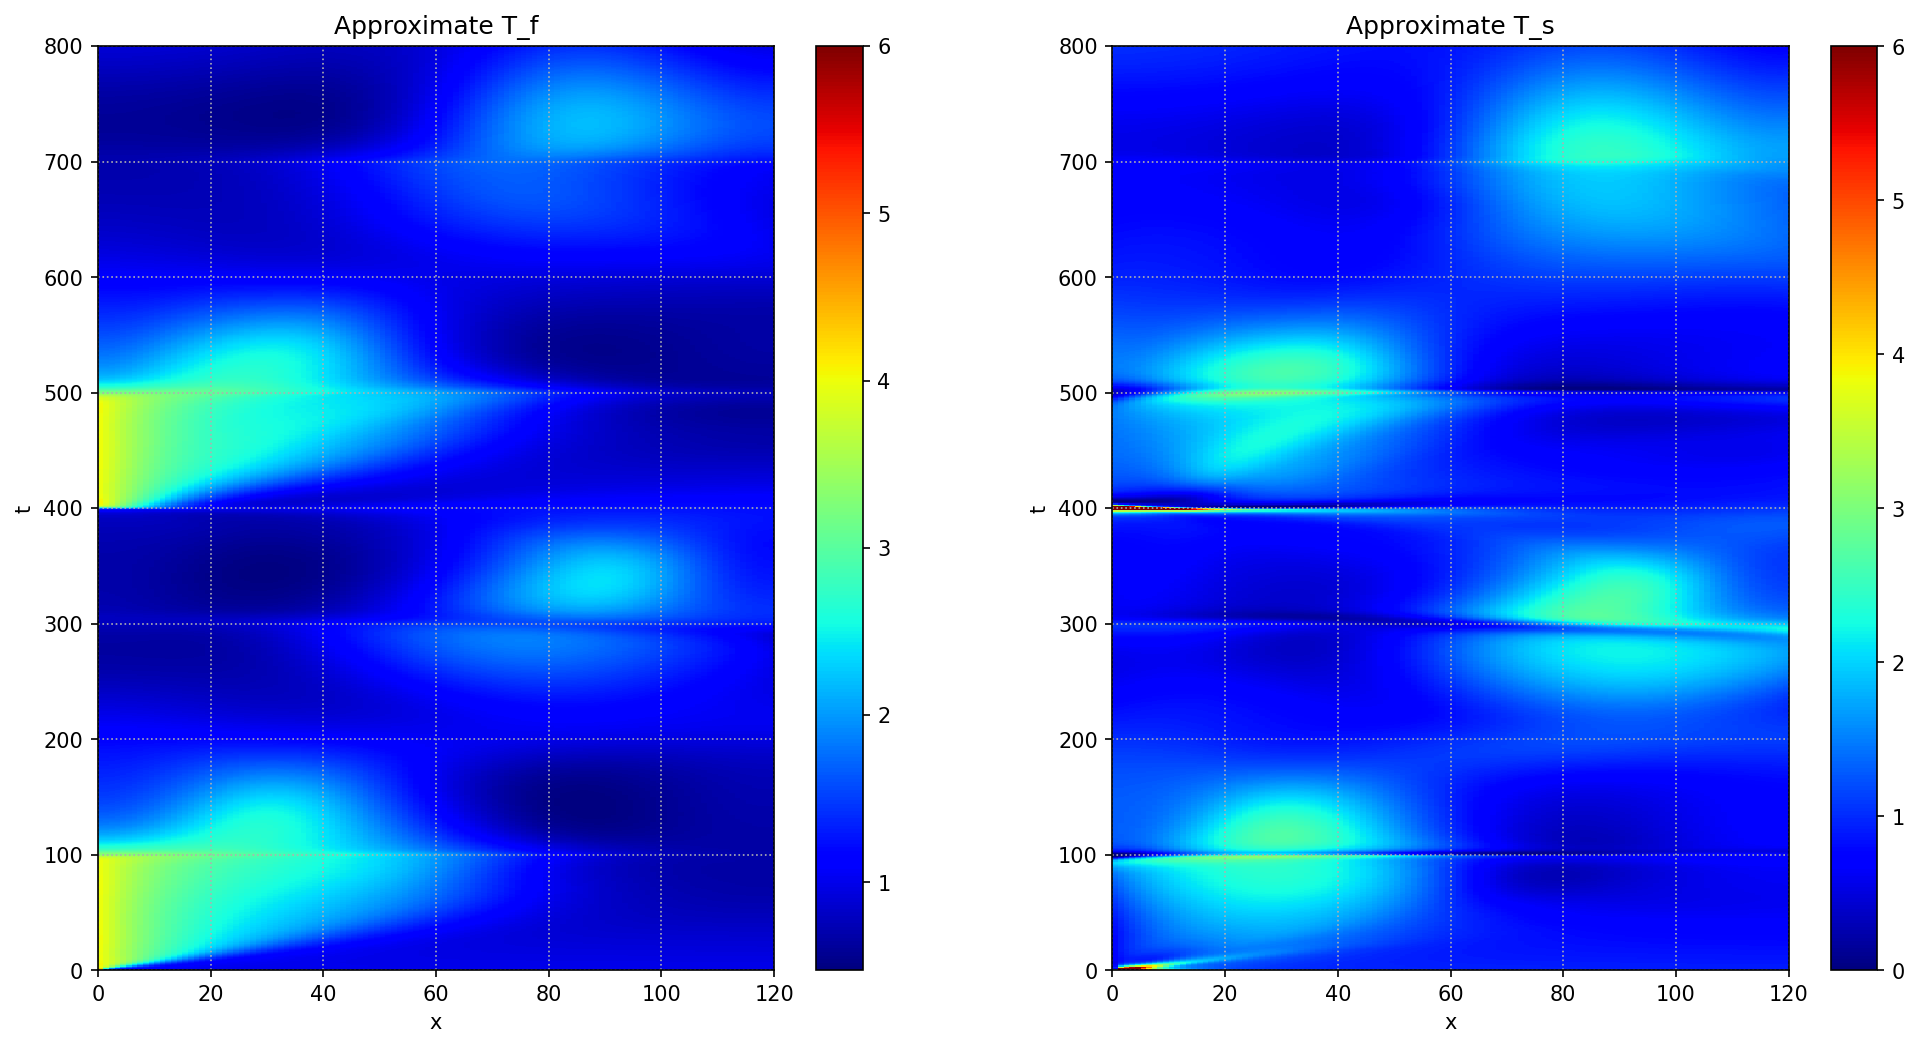

In [ ]:
mesh_plotting(pinn, print_max=True)

In [ ]:
# save(pinn, hist)

In [ ]:
# torch.save(pinn.approximate_solution.state_dict(), join("..","models", "task_2", "joint_1.47.pt"))
# torch.save(pinn.approximate_coefficient.state_dict(), join("models", "task_2", "ts.pt"))